### Action item:
SEMPRE I RAPPORTI
1. fit legge in l a tau fisso per captare la dipendenza in l (t fiduciale, quello dell'ultimo paper di planck pag 19) (0 <l < 30 o 50)
2. fit legge in t a l del picco (circa l=5,6,7,8)
3. plot f(l)*g(t) 
4. dare più dati (affinare t) e cercare un'espressione unica c_ee(l,t) per l anche più grande di 50
5. cercare una smooth transition function in l che passi dal regime t^2 a e^(-2t) (magari dopo)

Farlo per EE , poi per TE

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysr import PySRRegressor

In [15]:
def accuracy(data, model):
    if len(data) != len(model):
        print('ERROR: array must have the same length!')
        return
    
    l = len(data)
    total_error = 0
    
    for i in range(l):
        error = abs((data[i] - model[i]) / data[i])
        total_error += error
    
    avg_error = total_error / l
    accuracy_percentage = 100 * (1 - avg_error)
    
    return accuracy_percentage

In [16]:
model = PySRRegressor()

In [17]:
cl_raw = pd.read_csv('CL_20_50.csv')
tau_real = 0.0561
t_reio = np.round(np.linspace(0.0261, 0.1261, 20, endpoint=True),4)
index = np.abs(t_reio - tau_real).argmin()
t_reio[index] = tau_real
cl_ref = cl_raw[(cl_raw['tau'] == np.min(cl_raw['tau']))]

ell = cl_raw['ell'].values
ee = cl_raw['EE'].values
te = cl_raw['TE'].values
tt = cl_raw['TT'].values
tau = cl_raw['tau'].values

a = len(t_reio)
b = len(ell)
alpha = int(b/a)

### we choose $\tau_{ref}=\tau_{min}=0.0261$

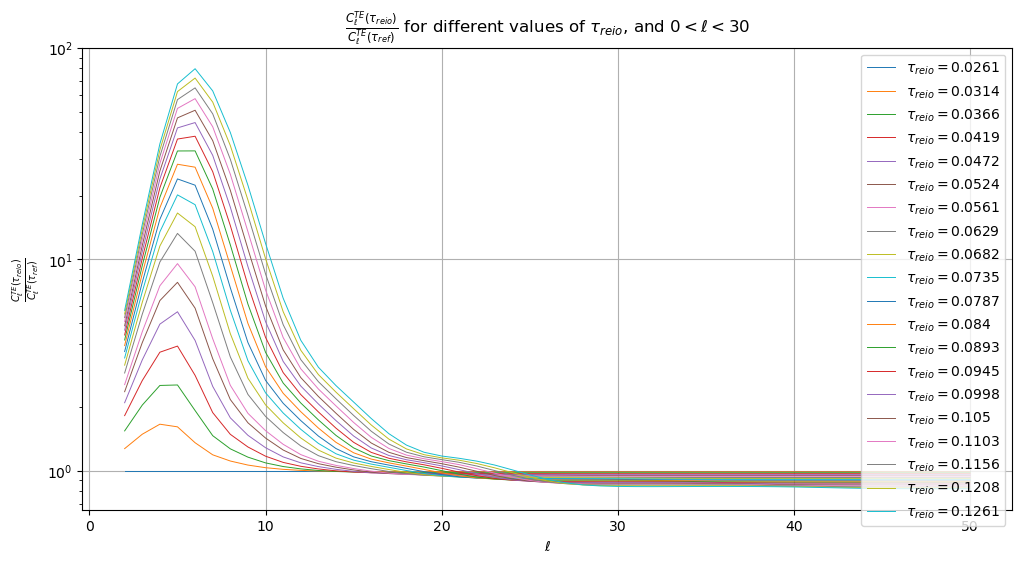

In [18]:
plt.figure(figsize=(12, 6))
ee_ratio = []
for i in range (a):
    l = ell[(i * alpha):(i + 1)*alpha]
    y = ee[(i * alpha):(i + 1)*alpha]/cl_ref['EE'][0:alpha]
    ee_ratio.append(y)
    string = r'$\tau_{reio}=$' + str(round(t_reio[i], 4))
    plt.semilogy(l,y, label=string, lw=0.7)
    plt.legend()
plt.xlabel('$\ell$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{ref})}$')
plt.title(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{ref})}$ for different values of $\tau_{reio}$, and $0<\ell<30}$')
plt.grid(True)
plt.show()  

In [19]:
l = ell[0:alpha]
ratio_used = ee_ratio[19]
Cl = pd.DataFrame({'ell':l,'EE/EE_ref':ratio_used})
Cl.to_csv('Ratio(l).csv', index=False) 

we sort the arrays to use $\tau$ as variable and $\ell$ fixed

In [20]:
ratio_arr = np.concatenate(ee_ratio)
x_t = []
x_l = []
y_ratio = []

for i in range (alpha):
    for j in range (a):
        index = int(i+j*alpha)
        x_t.append(tau[index])
        x_l.append(ell[index])
        y_ratio.append(ratio_arr[index]) 

In [21]:
df = pd.DataFrame({'tau':x_t,'ell':x_l, 'EE/EE_ref':y_ratio})
cl_sort = df[(df['ell'] == 6)]
cl_sort.to_csv('Ratio(t)-l6.csv', index=False)

----
## Graphs for $f(\ell)$
----

$$0.105 e^{1.42 \cdot 0.711^{\ell} \ell^{2}} + 0.439 + \frac{8.28}{\ell}$$

Checking if ratio-ell-ee-1509.pkl exists...
Loading model from ratio-ell-ee-1509.pkl
The accuracy of this model is 91.58


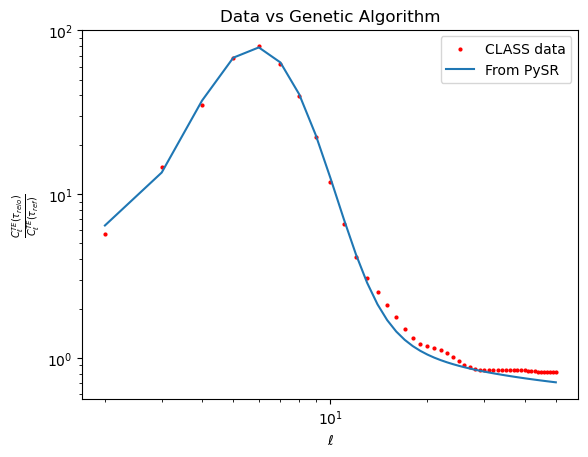

In [22]:
mod = model.from_file('ratio-ell-ee-1509.pkl')
l = l.reshape(-1,1)
ratio_used = np.array(ratio_used)

print('The accuracy of this model is', round(accuracy(ratio_used,mod.predict(l)),2))

plt.scatter(l,ratio_used, label='CLASS data', s=4, color='r')
plt.loglog(l,mod.predict(l), label='From PySR')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{ref})}$')
plt.title('Data vs Genetic Algorithm')
plt.legend()

----
## Graphs for $g(\tau)$
----

$$- 8.54 \cdot 10^{3} \tau^{2} \left(\tau + 0.383\right) + 1.33 \cdot 10^{4} \tau \left(\tau - 0.0430\right) + 9.56$$

Checking if ratio-tau-ee-1509.pkl exists...
Loading model from ratio-tau-ee-1509.pkl
The accuracy of this model is 95.99


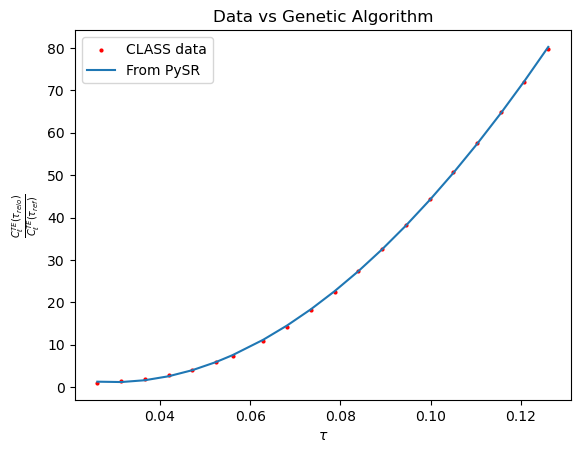

In [23]:
mod2 = model.from_file('ratio-tau-ee-1509.pkl')

t = t_reio.reshape(-1,1)
ratio_tau = np.array(df[(df['ell'] == 6)]['EE/EE_ref'])
print('The accuracy of this model is', np.round(accuracy(ratio_tau,mod2.predict(t)),2))

plt.scatter(t_reio,ratio_tau, label='CLASS data', s=4, color='r')
plt.plot(t_reio,mod2.predict(t), label='From PySR')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{ref})}$')
plt.title('Data vs Genetic Algorithm')
plt.legend()

### defining $\mathcal{F}(\ell,\tau):= \mathcal{N}h(\ell,\tau) = \mathcal{N}f(\ell)g(\tau)$

In [24]:
def h(ell,tau):
    f = 0.105 * np.exp(1.42 * 0.711**ell * ell**2) + 0.439 + 8.28 / ell
    g = (-8.54e3 * tau**2 * (tau + 0.383)) + (1.33e4 * tau * (tau - 0.0430)) + 9.56

    pr = f * g
    return pr

In [25]:
norm_ga = []

for i in range (a):
    z = np.max((ee[(i * alpha):(i + 1)*alpha]/ee[0:alpha]))*h(ell[(i * alpha):(i + 1)*alpha],tau[(i * alpha):(i + 1)*alpha])/np.max(h(ell[(i * alpha):(i + 1)*alpha],tau[(i * alpha):(i + 1)*alpha]))
    norm_ga.append(z)
F_ga = np.concatenate(norm_ga)

#### $$\mathcal{F}(\ell,\tau) := \mathcal{N}f(\ell)\cdot g(\tau) = \mathcal{N}(0.105 e^{1.42 \cdot 0.711^{\ell} \ell^{2}} + 0.439 + \frac{8.28}{\ell})\cdot(- 8.54 \cdot 10^{3} \tau^{2} \left(\tau + 0.383\right) + 1.33 \cdot 10^{4} \tau \left(\tau - 0.0430\right) + 9.56)$$

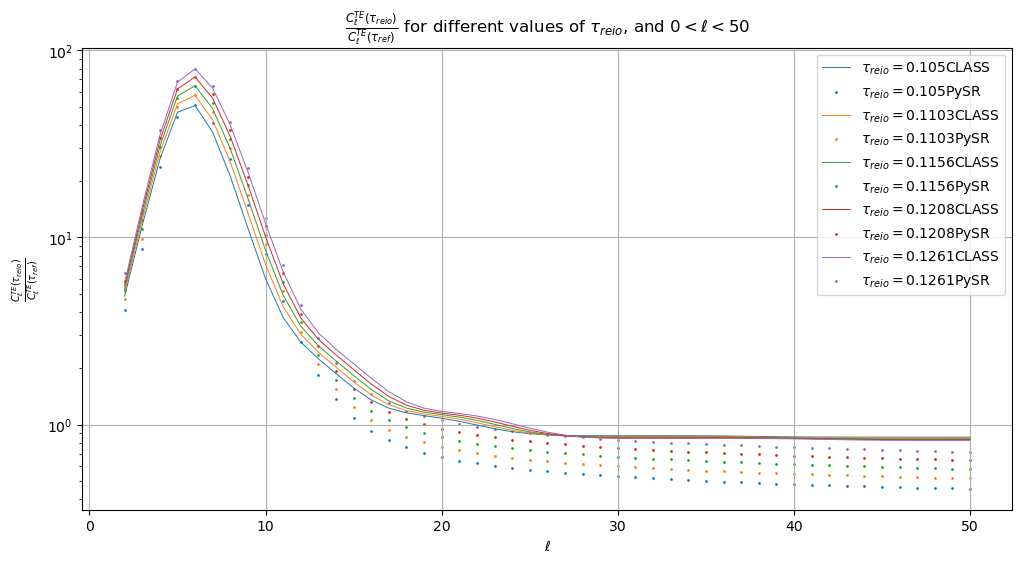

In [26]:
plt.figure(figsize=(12, 6))
norm_surf = []
for j in range (5):
    i = j+15
    l = ell[(i * alpha):(i + 1)*alpha]
    y = (ee[(i * alpha):(i + 1)*alpha]/ee[0:alpha])
    z = F_ga[(i * alpha):(i + 1)*alpha]
    norm_surf.append(z)
    string = r'$\tau_{reio}=$' + str(round(t_reio[i], 4)) + 'CLASS'
    string2 = r'$\tau_{reio}=$' + str(round(t_reio[i], 4)) + 'PySR'
    plt.semilogy(l,y, label=string, lw=0.7)
    plt.scatter(l,z, label=string2, s=1)
    plt.legend()
plt.xlabel('$\ell$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{ref})}$')
plt.title(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{ref})}$ for different values of $\tau_{reio}$, and $0<\ell<50}$')
plt.grid(True)
plt.show() 